<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/CA_LabelingData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workflow

This colab aims in labeling the CA data for super spread week, safe week and improvement week as per the 'number of cases' increasing or decreasing every week.

Idea: 
* compute 7 -day moving average
* 14 days data compare with next 14 days rolling window
* split the % as buckets 
* label the data as per bucket

In [198]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [199]:
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

In [200]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')


In [201]:
!ls  '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'

CA_combined_Sep09.csv		     CA_socialDistancingInertiaData_Sep09.csv
CA-CovidAug22.csv		     Maryland_University_SocialDistancing_Data
CA_labeledData_Sep09		     mask_rule.csv
CA_labeledData_Sep14.csv	     Newyork_combinedAug22.csv
CA_labeledData_Sep17.csv	     NY_sd_inertia_labeledData_Aug26.csv
CA_labeledData_Sep18.csv	     NY_socialDistancingInertiaDataAug25.csv
CA_sd_inertia_labeledData_Sep09      Social_Distancing_Inertia_County.csv
CA_sd_inertia_labeledData_Sep14.csv  TX_combined_Sep10.csv
CA_sd_inertia_labeledData_Sep17.csv  TX-Covid_Sep10.csv
CA_sd_inertia_labeledData_Sep18.csv  TX_socialDistancingInertiaData_Sep10.csv


# 1.1 Loading CA data

In [202]:
CA_combined_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/CA_combined_Sep09.csv',low_memory=False)
CA_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0
1,2020-03-02,6001,Alameda County,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0
2,2020-03-03,6001,Alameda County,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1
3,2020-03-04,6001,Alameda County,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.0,0
4,2020-03-05,6001,Alameda County,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.0,0


## Computing rolling average

In [203]:
CA_combined_data.iloc[:,15]

0        0
1        0
2        1
3        0
4        0
        ..
9191     0
9192    28
9193    35
9194     0
9195     8
Name: New cases, Length: 9196, dtype: int64

In [204]:
df = pd.DataFrame(columns=['Date','fips_x','County Name','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','population_density','mask_rule_active','mask_wearing_percent','New cases','rolling_avg_new_cases'])


In [205]:
CA_counties = CA_combined_data['County Name'].unique()

for county in CA_counties:
  county_data = CA_combined_data[CA_combined_data['County Name'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases'] = county_data.iloc[:,15].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,NaN
1,2020-03-02,6001,Alameda County,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0,NaN
2,2020-03-03,6001,Alameda County,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1,NaN
3,2020-03-04,6001,Alameda County,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.0,0,NaN
4,2020-03-05,6001,Alameda County,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.0,0,NaN


In [206]:
print(df.shape)
CA_combined_data.shape

(9196, 17)


(9196, 16)

In [207]:
CA_combined_data = df.copy()
CA_combined_data

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.000,0,NaN
1,2020-03-02,6001,Alameda County,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.000,0,NaN
2,2020-03-03,6001,Alameda County,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.000,1,NaN
3,2020-03-04,6001,Alameda County,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.000,0,NaN
4,2020-03-05,6001,Alameda County,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.000,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9191,2020-08-17,6115,Yuba County,-11.0,12.0,0.0,-11.0,-34.0,7.0,64.29,4.100,43,124.506204,1,0.669,0,16.000000
9192,2020-08-18,6115,Yuba County,-13.0,9.0,0.0,-21.0,-32.0,8.0,54.39,4.944,52,124.506204,1,0.669,28,17.142857
9193,2020-08-19,6115,Yuba County,-13.0,5.0,0.0,-22.0,-33.0,8.0,61.72,4.090,43,124.506204,1,0.669,35,20.428571
9194,2020-08-20,6115,Yuba County,-13.0,11.0,0.0,-19.0,-33.0,8.0,59.48,4.096,43,124.506204,1,0.669,0,19.000000


In [208]:
CA_combined_data[CA_combined_data['Date'] == '2020-08-01']

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
151,2020-08-01,6001,Alameda County,-44.0,-13.0,28.0,-49.0,-19.0,9.0,9.45,1.041,16,2261.547725,1,0.795,345,164.857143
323,2020-08-01,6005,Amador County,-9.0,12.0,0.0,0.0,-15.0,0.0,123.25,2.433,18,66.857277,1,0.655,10,7.714286
495,2020-08-01,6007,Butte County,-21.0,2.0,39.0,0.0,-15.0,3.0,55.33,2.452,53,133.939112,1,0.626,0,26.142857
667,2020-08-01,6009,Calaveras County,-31.0,0.0,0.0,0.0,-10.0,0.0,154.27,5.737,33,45.004461,1,0.562,0,3.714286
839,2020-08-01,6011,Colusa County,-14.0,0.0,0.0,-18.0,-5.0,0.0,138.38,10.870,75,18.724636,1,0.700,0,8.571429
1011,2020-08-01,6013,Contra Costa County,-34.0,-3.0,24.0,-33.0,-21.0,7.0,25.51,1.790,23,1611.204850,1,0.806,136,148.000000
1183,2020-08-01,6015,Del Norte County,32.0,48.0,0.0,0.0,-3.0,0.0,388.59,2.082,92,27.635959,1,0.547,0,0.142857
1355,2020-08-01,6017,El Dorado County,-13.0,9.0,161.0,3.0,-17.0,4.0,174.95,4.362,44,112.913671,1,0.675,0,17.714286
1527,2020-08-01,6019,Fresno County,-24.0,0.0,30.0,-16.0,-15.0,4.0,47.48,1.743,26,167.690949,1,0.741,0,267.857143
1699,2020-08-01,6021,Glenn County,-13.0,5.0,0.0,26.0,-15.0,0.0,135.39,5.116,35,21.608889,1,0.594,0,8.571429


In [209]:
CA_combined_data.head(8)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,NaN
1,2020-03-02,6001,Alameda County,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0,NaN
2,2020-03-03,6001,Alameda County,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1,NaN
3,2020-03-04,6001,Alameda County,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.0,0,NaN
4,2020-03-05,6001,Alameda County,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.0,0,NaN
5,2020-03-06,6001,Alameda County,1.0,5.0,-1.0,-7.0,0.0,2.0,25.77,6.704,106,2261.547725,0,0.0,0,NaN
6,2020-03-07,6001,Alameda County,-6.0,4.0,-23.0,-14.0,1.0,3.0,12.82,4.869,77,2261.547725,0,0.0,1,0.285714
7,2020-03-08,6001,Alameda County,-2.0,4.0,14.0,-8.0,1.0,1.0,-14.65,3.408,54,2261.547725,0,0.0,0,0.285714


## clean data - fill NA 

In [210]:
CA_combined_data = CA_combined_data.fillna(0)
CA_combined_data.head(8)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.000000
1,2020-03-02,6001,Alameda County,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0,0.000000
2,2020-03-03,6001,Alameda County,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1,0.000000
3,2020-03-04,6001,Alameda County,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.0,0,0.000000
4,2020-03-05,6001,Alameda County,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.0,0,0.000000
5,2020-03-06,6001,Alameda County,1.0,5.0,-1.0,-7.0,0.0,2.0,25.77,6.704,106,2261.547725,0,0.0,0,0.000000
6,2020-03-07,6001,Alameda County,-6.0,4.0,-23.0,-14.0,1.0,3.0,12.82,4.869,77,2261.547725,0,0.0,1,0.285714
7,2020-03-08,6001,Alameda County,-2.0,4.0,14.0,-8.0,1.0,1.0,-14.65,3.408,54,2261.547725,0,0.0,0,0.285714


In [211]:
CA_combined_data['County Name'].unique()

array(['Alameda County', 'Amador County', 'Butte County',
       'Calaveras County', 'Colusa County', 'Contra Costa County',
       'Del Norte County', 'El Dorado County', 'Fresno County',
       'Glenn County', 'Humboldt County', 'Imperial County',
       'Inyo County', 'Kern County', 'Kings County', 'Lake County',
       'Lassen County', 'Los Angeles County', 'Madera County',
       'Marin County', 'Mariposa County', 'Mendocino County',
       'Merced County', 'Mono County', 'Monterey County', 'Napa County',
       'Nevada County', 'Orange County', 'Placer County', 'Plumas County',
       'Riverside County', 'Sacramento County', 'San Benito County',
       'San Bernardino County', 'San Diego County',
       'San Francisco County', 'San Joaquin County',
       'San Luis Obispo County', 'San Mateo County',
       'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County',
       'Shasta County', 'Siskiyou County', 'Solano County',
       'Sonoma County', 'Stanislaus County', 'Su

## verifying Rolling average with visualizations -Los Angeles County

In [212]:
los_angeles_county = CA_combined_data[CA_combined_data['County Name'] == 'Los Angeles County']
print(los_angeles_county.shape)
los_angeles_county.head()

(172, 17)


,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
2924,2020-03-01,6037,Los Angeles County,4.0,3.0,-5.0,-3.0,1.0,0.0,-4.36,3.996,60,2473.978284,0,0.0,0,0.0
2925,2020-03-02,6037,Los Angeles County,5.0,5.0,8.0,1.0,4.0,-1.0,7.51,6.502,98,2473.978284,0,0.0,0,0.0
2926,2020-03-03,6037,Los Angeles County,8.0,7.0,32.0,2.0,3.0,-1.0,17.24,6.591,99,2473.978284,0,0.0,0,0.0
2927,2020-03-04,6037,Los Angeles County,4.0,6.0,9.0,-1.0,2.0,0.0,13.82,6.595,100,2473.978284,0,0.0,6,0.0
2928,2020-03-05,6037,Los Angeles County,4.0,7.0,9.0,0.0,2.0,0.0,22.17,7.008,106,2473.978284,0,0.0,4,0.0


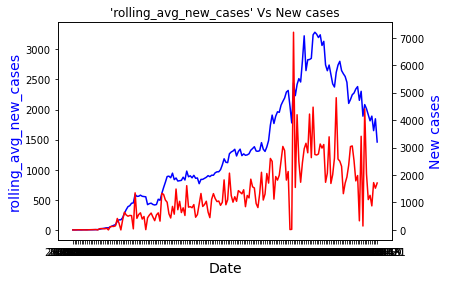

In [213]:
fig,ax = plt.subplots()
# make a plot
ax.plot(los_angeles_county.Date, los_angeles_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(los_angeles_county.Date, los_angeles_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

In [214]:
suffolk_county = CA_combined_data[CA_combined_data['County Name'] == 'Santa Clara County']

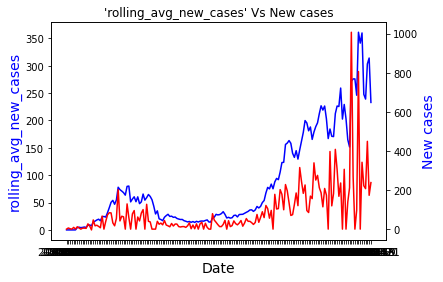

In [215]:
fig,ax = plt.subplots()
# make a plot
ax.plot(suffolk_county.Date, suffolk_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(suffolk_county.Date, suffolk_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

## Rolling window to compare every 2 weeks with next 2 weeks

In [216]:
CA_combined_data = CA_combined_data.sort_values(by=['Date'])
CA_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0
5240,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0
5412,2020-03-01,6069,San Benito County,2.0,-1.0,-7.0,0.0,0.0,0.0,10.40,3.876,33,45.227585,0,0.0,0,0.0
5584,2020-03-01,6071,San Bernardino County,5.0,-2.0,-22.0,2.0,-1.0,0.0,10.34,4.508,57,108.694796,0,0.0,0,0.0
5756,2020-03-01,6073,San Diego County,2.0,-1.0,-20.0,-4.0,2.0,0.0,-4.99,4.555,59,793.587741,0,0.0,0,0.0


In [217]:
CA_combined_data[CA_combined_data['fips_x'] == 6037]

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
2924,2020-03-01,6037,Los Angeles County,4.0,3.0,-5.0,-3.0,1.0,0.0,-4.36,3.996,60,2473.978284,0,0.000,0,0.000000
2925,2020-03-02,6037,Los Angeles County,5.0,5.0,8.0,1.0,4.0,-1.0,7.51,6.502,98,2473.978284,0,0.000,0,0.000000
2926,2020-03-03,6037,Los Angeles County,8.0,7.0,32.0,2.0,3.0,-1.0,17.24,6.591,99,2473.978284,0,0.000,0,0.000000
2927,2020-03-04,6037,Los Angeles County,4.0,6.0,9.0,-1.0,2.0,0.0,13.82,6.595,100,2473.978284,0,0.000,6,0.000000
2928,2020-03-05,6037,Los Angeles County,4.0,7.0,9.0,0.0,2.0,0.0,22.17,7.008,106,2473.978284,0,0.000,4,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3091,2020-08-17,6037,Los Angeles County,-29.0,-13.0,-10.0,-41.0,-42.0,13.0,1.14,1.472,22,2473.978284,1,0.786,1259,1812.428571
3092,2020-08-18,6037,Los Angeles County,-31.0,-13.0,-11.0,-43.0,-42.0,15.0,3.51,2.137,32,2473.978284,1,0.786,875,1890.142857
3093,2020-08-19,6037,Los Angeles County,-30.0,-13.0,-9.0,-43.0,-42.0,15.0,6.42,1.656,25,2473.978284,1,0.786,1722,1649.142857
3094,2020-08-20,6037,Los Angeles County,-30.0,-13.0,-9.0,-43.0,-42.0,15.0,8.13,2.227,33,2473.978284,1,0.786,1519,1845.857143


In [218]:
minDate = CA_combined_data['Date'].min()
print(minDate)

dateList = CA_combined_data['Date'].unique()

2020-03-01


In [219]:
import datetime

#dt_object = datetime.fromtimestamp(date)
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

day = datetime.datetime.strptime(minDate, '%Y-%m-%d').weekday()
if day == 6:
  day =0
elif day < 6:
  day += 1

print(day)

0


In [220]:
index = 0
count = 0
lst = []
while index < len(dateList):
  row = []
  j = 14 - day;
  # print(index,j)
  # print(dateList[index:index+j])
  weekRange = dateList[index:index+j]
  #print(weekRange)
  index = index+j 
  day = 0
  count +=1
  row.append(count)
  row.append(weekRange.min())
  row.append(weekRange.max())
  print(row)
  lst.append(row)
  


[1, '2020-03-01', '2020-03-14']
[2, '2020-03-15', '2020-03-28']
[3, '2020-03-29', '2020-04-11']
[4, '2020-04-12', '2020-04-26']
[5, '2020-04-27', '2020-05-10']
[6, '2020-05-11', '2020-05-24']
[7, '2020-05-25', '2020-06-08']
[8, '2020-06-09', '2020-06-22']
[9, '2020-06-23', '2020-07-06']
[10, '2020-07-07', '2020-07-20']
[11, '2020-07-21', '2020-08-03']
[12, '2020-08-04', '2020-08-17']
[13, '2020-08-18', '2020-08-21']


In [221]:
week_df = pd.DataFrame(lst,index=None,columns=['WeekNumber','startDate','endDate'])
week_df.head(2)

,WeekNumber,startDate,endDate
0,1,2020-03-01,2020-03-14
1,2,2020-03-15,2020-03-28


## Slice data for the week dataframe

In [222]:

average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in week_df.iterrows():
    startDate, endDate = row['startDate'], row['endDate']
    df_index = (CA_combined_data['Date'] >= startDate) & (CA_combined_data['Date'] <= endDate)
    df_weekData =  CA_combined_data.loc[df_index]
    df_base = (
      df_weekData
      .pipe(lambda x: x.assign(gains_pctg=x["rolling_avg_new_cases"]))
      .groupby(['County Name','fips_x'])
      .agg({"gains_pctg": "mean"})
      .reset_index()
      .rename(columns={"gains_pctg": "average_per_week"})
    )
    df_base['startDate'] = startDate
    df_base['endDate'] = endDate
  
    #print(startDate,endDate,df_base['average_per_week'])
    average_newCases_df = average_newCases_df.append(df_base)


In [223]:
average_newCases_df.shape

(701, 5)

In [224]:
average_newCases_df[average_newCases_df['fips_x'] == 6037]

,County Name,fips_x,average_per_week,startDate,endDate
17,Los Angeles County,6037,1.683673,2020-03-01,2020-03-14
17,Los Angeles County,6037,65.061224,2020-03-15,2020-03-28
17,Los Angeles County,6037,460.224490,2020-03-29,2020-04-11
17,Los Angeles County,6037,593.397959,2020-04-12,2020-04-26
17,Los Angeles County,6037,870.357143,2020-04-27,2020-05-10
17,Los Angeles County,6037,894.602041,2020-05-11,2020-05-24
17,Los Angeles County,6037,1237.336735,2020-05-25,2020-06-08
17,Los Angeles County,6037,1371.520408,2020-06-09,2020-06-22
17,Los Angeles County,6037,2071.102041,2020-06-23,2020-07-06
17,Los Angeles County,6037,2912.918367,2020-07-07,2020-07-20


## Verifying average per week data Eg., Los Angeles County

In [225]:
los_angeles_county[(los_angeles_county['Date'] >= '2020-03-01') & (los_angeles_county['Date'] <= '2020-03-14') ]['rolling_avg_new_cases']



2924    0.000000
2925    0.000000
2926    0.000000
2927    0.000000
2928    0.000000
2929    0.000000
2930    1.857143
2931    1.857143
2932    1.857143
2933    2.714286
2934    2.857143
2935    3.000000
2936    3.857143
2937    5.571429
Name: rolling_avg_new_cases, dtype: float64

In [226]:
average_newCases_df.head(10)

,County Name,fips_x,average_per_week,startDate,endDate
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14
1,Amador County,6005,0.000000,2020-03-01,2020-03-14
2,Butte County,6007,0.000000,2020-03-01,2020-03-14
3,Calaveras County,6009,0.081633,2020-03-01,2020-03-14
4,Colusa County,6011,0.000000,2020-03-01,2020-03-14
5,Contra Costa County,6013,1.051020,2020-03-01,2020-03-14
6,Del Norte County,6015,0.000000,2020-03-01,2020-03-14
7,El Dorado County,6017,0.000000,2020-03-01,2020-03-14
8,Fresno County,6019,0.091837,2020-03-01,2020-03-14
9,Glenn County,6021,0.000000,2020-03-01,2020-03-14


## Finding the % growth or reduction in 'new cases' on every 2 week average

In [227]:
average_newCases_df_ = average_newCases_df.copy()

In [228]:
albany_avg_newCases = average_newCases_df[average_newCases_df['County Name'] == 'Los Angeles County']
albany_avg_newCases

,County Name,fips_x,average_per_week,startDate,endDate
17,Los Angeles County,6037,1.683673,2020-03-01,2020-03-14
17,Los Angeles County,6037,65.061224,2020-03-15,2020-03-28
17,Los Angeles County,6037,460.224490,2020-03-29,2020-04-11
17,Los Angeles County,6037,593.397959,2020-04-12,2020-04-26
17,Los Angeles County,6037,870.357143,2020-04-27,2020-05-10
17,Los Angeles County,6037,894.602041,2020-05-11,2020-05-24
17,Los Angeles County,6037,1237.336735,2020-05-25,2020-06-08
17,Los Angeles County,6037,1371.520408,2020-06-09,2020-06-22
17,Los Angeles County,6037,2071.102041,2020-06-23,2020-07-06
17,Los Angeles County,6037,2912.918367,2020-07-07,2020-07-20


In [229]:
# average_newCases_df = average_newCases_df.sort_values(by=['startDate','endDate'])

# print(average_newCases_df.shape)
# temp = average_newCases_df.groupby(['County Name','fips_x','startDate','endDate'])['average_per_week']
# temp = temp.sum().diff().reset_index()
# print("-------------")
# print(temp)
# print(temp.shape)

# average_newCases_df2 = average_newCases_df.merge(temp,on=['County Name','fips_x','startDate','endDate'])
# print(average_newCases_df2.shape)

In [230]:
average_newCases_df.head()

,County Name,fips_x,average_per_week,startDate,endDate
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14
1,Amador County,6005,0.000000,2020-03-01,2020-03-14
2,Butte County,6007,0.000000,2020-03-01,2020-03-14
3,Calaveras County,6009,0.081633,2020-03-01,2020-03-14
4,Colusa County,6011,0.000000,2020-03-01,2020-03-14


In [231]:
# average_newCases_df = average_newCases_df.sort_values(by=['startDate','endDate'])

# print(average_newCases_df.shape)
# temp = average_newCases_df.groupby(['County Name','fips_x','startDate','endDate'])['average_per_week']
# temp = temp.sum().diff().reset_index()
# print("-------------")
# print(temp)
# print(temp.shape)

# average_newCases_df2 = average_newCases_df.merge(temp,on=['County Name','fips_x','startDate','endDate'])
# print(average_newCases_df2.shape)

In [232]:
average_newCases_df2 = average_newCases_df.copy()

average_newCases_df2 = average_newCases_df2.reset_index(drop=True)
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14
1,Amador County,6005,0.000000,2020-03-01,2020-03-14
2,Butte County,6007,0.000000,2020-03-01,2020-03-14
3,Calaveras County,6009,0.081633,2020-03-01,2020-03-14
4,Colusa County,6011,0.000000,2020-03-01,2020-03-14


In [233]:
average_newCases_df2['diff_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x'])['average_per_week'].diff().fillna(0)

print(average_newCases_df2.shape)
average_newCases_df2.head()


(701, 6)


,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14,0.0
1,Amador County,6005,0.000000,2020-03-01,2020-03-14,0.0
2,Butte County,6007,0.000000,2020-03-01,2020-03-14,0.0
3,Calaveras County,6009,0.081633,2020-03-01,2020-03-14,0.0
4,Colusa County,6011,0.000000,2020-03-01,2020-03-14,0.0


In [234]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Santa Clara County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
40,Santa Clara County,6085,3.224490,2020-03-01,2020-03-14,0.000000
94,Santa Clara County,6085,27.683673,2020-03-15,2020-03-28,24.459184
147,Santa Clara County,6085,64.071429,2020-03-29,2020-04-11,36.387755
201,Santa Clara County,6085,42.714286,2020-04-12,2020-04-26,-21.357143
255,Santa Clara County,6085,20.908163,2020-04-27,2020-05-10,-21.806122
309,Santa Clara County,6085,16.489796,2020-05-11,2020-05-24,-4.418367
363,Santa Clara County,6085,26.387755,2020-05-25,2020-06-08,9.897959
417,Santa Clara County,6085,37.612245,2020-06-09,2020-06-22,11.224490
471,Santa Clara County,6085,105.969388,2020-06-23,2020-07-06,68.357143
525,Santa Clara County,6085,164.336735,2020-07-07,2020-07-20,58.367347


In [235]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Alameda County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14,0.000000
54,Alameda County,6001,10.632653,2020-03-15,2020-03-28,10.316327
108,Alameda County,6001,37.051020,2020-03-29,2020-04-11,26.418367
161,Alameda County,6001,45.193878,2020-04-12,2020-04-26,8.142857
215,Alameda County,6001,41.561224,2020-04-27,2020-05-10,-3.632653
269,Alameda County,6001,51.530612,2020-05-11,2020-05-24,9.969388
323,Alameda County,6001,69.744898,2020-05-25,2020-06-08,18.214286
377,Alameda County,6001,73.724490,2020-06-09,2020-06-22,3.979592
431,Alameda County,6001,122.785714,2020-06-23,2020-07-06,49.061224
485,Alameda County,6001,169.846939,2020-07-07,2020-07-20,47.061224


In [236]:
average_newCases_df2[average_newCases_df2['fips_x'] == 6037].head(5)

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
17,Los Angeles County,6037,1.683673,2020-03-01,2020-03-14,0.000000
71,Los Angeles County,6037,65.061224,2020-03-15,2020-03-28,63.377551
125,Los Angeles County,6037,460.224490,2020-03-29,2020-04-11,395.163265
178,Los Angeles County,6037,593.397959,2020-04-12,2020-04-26,133.173469
232,Los Angeles County,6037,870.357143,2020-04-27,2020-05-10,276.959184


In [237]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14,0.0
1,Amador County,6005,0.000000,2020-03-01,2020-03-14,0.0
2,Butte County,6007,0.000000,2020-03-01,2020-03-14,0.0
3,Calaveras County,6009,0.081633,2020-03-01,2020-03-14,0.0
4,Colusa County,6011,0.000000,2020-03-01,2020-03-14,0.0


In [238]:
average_newCases_df2 = average_newCases_df2.fillna(0)

In [239]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14,0.0
1,Amador County,6005,0.000000,2020-03-01,2020-03-14,0.0
2,Butte County,6007,0.000000,2020-03-01,2020-03-14,0.0
3,Calaveras County,6009,0.081633,2020-03-01,2020-03-14,0.0
4,Colusa County,6011,0.000000,2020-03-01,2020-03-14,0.0


In [240]:
#not working
#average_newCases_df2['pct_change_newcases'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x','startDate','endDate']).average_per_week_y.pct_change()

Shifting average_per_week_x	 column value for formula. Means previous row's value will be come to the current row.

In [241]:
average_newCases_df2['shift_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x'])['average_per_week'].shift()

In [242]:
average_newCases_df2.groupby(by=['County Name', 'fips_x','startDate','endDate']).sum()

average_per_week  ...  shift_avg_x
County Name    fips_x startDate  endDate                       ...             
Alameda County 6001   2020-03-01 2020-03-14          0.316327  ...     0.000000
                      2020-03-15 2020-03-28         10.632653  ...     0.316327
                      2020-03-29 2020-04-11         37.051020  ...    10.632653
                      2020-04-12 2020-04-26         45.193878  ...    37.051020
                      2020-04-27 2020-05-10         41.561224  ...    45.193878
...                                                       ...  ...          ...
Yuba County    6115   2020-06-23 2020-07-06          4.387755  ...     0.632653
                      2020-07-07 2020-07-20         10.377551  ...     4.387755
                      2020-07-21 2020-08-03         15.040816  ...    10.377551
                      2020-08-04 2020-08-17         18.632653  ...    15.040816
                      2020-08-18 2020-08-21         17.321429  ...    18.632653

[701 rows x 3 columns]

In [243]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Los Angeles County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x
17,Los Angeles County,6037,1.683673,2020-03-01,2020-03-14,0.000000,NaN
71,Los Angeles County,6037,65.061224,2020-03-15,2020-03-28,63.377551,1.683673
125,Los Angeles County,6037,460.224490,2020-03-29,2020-04-11,395.163265,65.061224
178,Los Angeles County,6037,593.397959,2020-04-12,2020-04-26,133.173469,460.224490
232,Los Angeles County,6037,870.357143,2020-04-27,2020-05-10,276.959184,593.397959
286,Los Angeles County,6037,894.602041,2020-05-11,2020-05-24,24.244898,870.357143
340,Los Angeles County,6037,1237.336735,2020-05-25,2020-06-08,342.734694,894.602041
394,Los Angeles County,6037,1371.520408,2020-06-09,2020-06-22,134.183673,1237.336735
448,Los Angeles County,6037,2071.102041,2020-06-23,2020-07-06,699.581633,1371.520408
502,Los Angeles County,6037,2912.918367,2020-07-07,2020-07-20,841.816327,2071.102041


In [244]:
average_newCases_df2['percent_newcases'] = average_newCases_df2.apply(lambda x: (x.diff_avg_x) / x.shift_avg_x if x.shift_avg_x > 0.0 else 0 , axis=1)


average_newCases_df2.tail()


,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
696,Tulare County,6107,152.428571,2020-08-18,2020-08-21,-36.540816,188.969388,-0.193369
697,Tuolumne County,6109,1.214286,2020-08-18,2020-08-21,-0.336735,1.551020,-0.217105
698,Ventura County,6111,98.500000,2020-08-18,2020-08-21,-27.255102,125.755102,-0.216732
699,Yolo County,6113,31.750000,2020-08-18,2020-08-21,0.178571,31.571429,0.005656
700,Yuba County,6115,17.321429,2020-08-18,2020-08-21,-1.311224,18.632653,-0.070372


In [245]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Los Angeles County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
17,Los Angeles County,6037,1.683673,2020-03-01,2020-03-14,0.000000,NaN,0.000000
71,Los Angeles County,6037,65.061224,2020-03-15,2020-03-28,63.377551,1.683673,37.642424
125,Los Angeles County,6037,460.224490,2020-03-29,2020-04-11,395.163265,65.061224,6.073714
178,Los Angeles County,6037,593.397959,2020-04-12,2020-04-26,133.173469,460.224490,0.289366
232,Los Angeles County,6037,870.357143,2020-04-27,2020-05-10,276.959184,593.397959,0.466734
286,Los Angeles County,6037,894.602041,2020-05-11,2020-05-24,24.244898,870.357143,0.027856
340,Los Angeles County,6037,1237.336735,2020-05-25,2020-06-08,342.734694,894.602041,0.383114
394,Los Angeles County,6037,1371.520408,2020-06-09,2020-06-22,134.183673,1237.336735,0.108446
448,Los Angeles County,6037,2071.102041,2020-06-23,2020-07-06,699.581633,1371.520408,0.510077
502,Los Angeles County,6037,2912.918367,2020-07-07,2020-07-20,841.816327,2071.102041,0.406458


# 1.2 Labeling data as per % change

In [246]:
average_newCases_df2.describe()

,fips_x,average_per_week,diff_avg_x,shift_avg_x,percent_newcases
count,701.000000,701.000000,701.000000,647.000000,701.000000
mean,6057.724679,72.344621,10.945282,66.505312,1.635755
std,32.987094,237.898878,72.155794,233.986807,6.209127
min,6001.000000,-1.892857,-537.673469,-0.357143,-2.500000
25%,6029.000000,0.530612,-0.030612,0.423469,-0.019417
50%,6059.000000,6.020408,0.581633,5.204082,0.190476
75%,6085.000000,42.867347,7.857143,37.923469,0.960000
max,6115.000000,2912.918367,841.816327,2912.918367,95.421053


In [247]:
los_angeles_county = average_newCases_df2[average_newCases_df2['County Name'] == 'Los Angeles County']

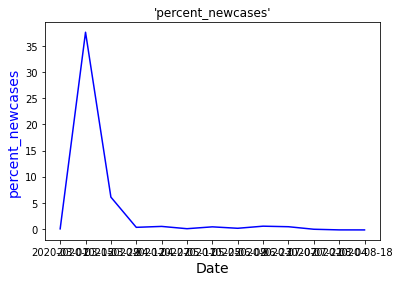

In [248]:
fig,ax = plt.subplots()
# make a plot
ax.plot(los_angeles_county.startDate, los_angeles_county['percent_newcases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("percent_newcases",color="blue",fontsize=14)
# ax2=ax.twinx()
# make a plot with different y-axis using second axis object
# ax2.plot(los_angeles_county.startDate, los_angeles_county["percent_newcases"],color="red")
# ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'percent_newcases'")

plt.show()

In [249]:
data = average_newCases_df2['percent_newcases'].to_list()

print(data)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.61290322580645, 0.0, 0.0, 0.12499999999999997, 0.0, 5.446601941747573, 0.0, 0.0, 11.333333333333332, 0.0, 0.0, 10.333333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 37.64242424242425, 4.571428571428573, 26.38461538461538, 0.0, 0.0, 0.0, 0.0, 0.0, 12.000000000000002, 0.0, 44.24242424242424, 2.96969696969697, 0.0, 13.166666666666666, 8.391891891891893, 44.0, 0.0, 95.42105263157892, 10.387387387387385, 25.812500000000004, 0.0, 12.266666666666664, 0.0, 7.585443037974684, 5.90909090909091, 0.8333333333333334, 0.0, 4.333333333333332, 18.0, 9.124999999999998, 0.0, 0.0, 29.000000000000004, 0.0, 33.99999999999999, 7.8571428571428585, 0.0, 2.4846449136276387, 0.16666666666666677, 1.6249999999999998, 1.5555555555555556, 15.9999999999999

In [250]:
average_newCases_df3 = average_newCases_df2.copy().reset_index(drop=True)

In [251]:
average_newCases_df3.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14,0.0,NaN,0.0
1,Amador County,6005,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0
2,Butte County,6007,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0
3,Calaveras County,6009,0.081633,2020-03-01,2020-03-14,0.0,NaN,0.0
4,Colusa County,6011,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0


In [252]:
new_cases_list = average_newCases_df2['percent_newcases'].values

## Determining growth label for covid cases

#### Getting diff array

In [253]:
len(new_cases_list)

701

In [254]:
diffArr = np.diff(new_cases_list)
print(len(diffArr))
diffArr[0]

700


0.0

In [255]:
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
print('growth_values : ',len(growth_values))
growth_values.extend(diffArr)
print('growth_values : ',len(growth_values))


growth_values :  1
growth_values :  701


In [256]:
len(growth_values)

701

In [257]:
average_newCases_df2['growth_per_day'] = growth_values

In [258]:
average_newCases_df2.dtypes

County Name          object
fips_x                int64
average_per_week    float64
startDate            object
endDate              object
diff_avg_x          float64
shift_avg_x         float64
percent_newcases    float64
growth_per_day      float64
dtype: object

### Checking mean, std dev and variance for growth data

In [259]:
stdDev = np.std(diffArr)
variance = np.var(diffArr)
mean = np.mean(diffArr)
min = np.min(diffArr)
max = np.max(diffArr)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  -85.03366524419152
max  95.42105263157892
mean  -0.00010053199812239003
std. deviation  8.272630184644905
variance  68.436410171898


#### Getting positive cases

In [260]:
print('length diffArr: ',len(diffArr))

non_zero_pos_diff = []

for i in diffArr:
  if i > 0:
    non_zero_pos_diff.append(i)

print('non_zero_pos_diff length: ',len(non_zero_pos_diff))

length diffArr:  700
non_zero_pos_diff length:  327


In [261]:
stdDev = np.std(non_zero_pos_diff)
variance = np.var(non_zero_pos_diff)
mean = np.mean(non_zero_pos_diff)
min = np.min(non_zero_pos_diff)
max = np.max(non_zero_pos_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  0.00037368250226338384
max  95.42105263157892
mean  2.8502460410605934
std. deviation  8.076797964026245
variance  65.23466535169848


#### Getting negative cases

In [262]:
print('length diffArr: ',len(diffArr))

non_zero_neg_diff = []

for i in diffArr:
  if i < 0:
    non_zero_neg_diff.append(i)
print("non_zero_neg_diff length : ",len(non_zero_neg_diff))


length diffArr:  700
non_zero_neg_diff length :  306


In [263]:
stdDev = np.std(non_zero_neg_diff)
variance = np.var(non_zero_neg_diff)
mean = np.mean(non_zero_neg_diff)
min = np.min(non_zero_neg_diff)
max = np.max(non_zero_neg_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  -85.03366524419152
max  -0.012359010805333276
mean  -3.0460811366846396
std. deviation  8.299535519829378
variance  68.88228984490952


### Trying natural breaks

In [264]:
!pip install jenkspy


In [265]:
import jenkspy

In [266]:
pos_breaks = jenkspy.jenks_breaks(non_zero_pos_diff, nb_class=2)
print(pos_breaks)
neg_breaks = jenkspy.jenks_breaks(non_zero_neg_diff, nb_class=2)
print(neg_breaks)

[0.00037368250226338384, 21.813186813186807, 95.42105263157892]
[-85.03366524419152, -19.08752860411899, -0.012359010805333276]


##### **Note**: 
From the positive and negative break, 
* [ -0.012359, 0.000374 ] - flat growth
* [ 0.000374, 21.813186 ] - mild growth
* [ 21.813186, 95.421053 ] - drastic growth
* [ -0.012359, -21.813186 ] - mild decrement
* [ -21.813186, -95.421053 ] - drastic decrement

In [267]:
def determine_growth_label(x):
  if x >= -0.012359 and x <= 0.000374:
    return 'flat_growth'
  if x > 0.000374 and x <= 21.813186:
    return 'mild_growth'
  if x > 21.813186 and x <= 95.421053:
    return 'drastic_growth'
  if x >= -21.813186  and x <= -0.012359:
    return 'mild_decrement'
  if x >= -95.421053 and x < -21.813186:
    return 'drastic_decrement'


In [268]:
average_newCases_df2['growth_label'] = average_newCases_df2['growth_per_day'].apply(lambda x: determine_growth_label(x) )

In [269]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
1,Amador County,6005,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
2,Butte County,6007,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
3,Calaveras County,6009,0.081633,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
4,Colusa County,6011,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth


## Jenks Natural breaks 

In [270]:
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=3)
print(breaks)

[-2.5000000000000004, 13.882352941176471, 44.24242424242424, 95.42105263157892]


In [271]:
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=8)
print(breaks)

[-2.5000000000000004, 0.8571428571428573, 3.5725982532751104, 9.124999999999998, 21.000000000000004, 33.99999999999999, 44.24242424242424, 60.11538461538463, 95.42105263157892]


### Labeling criteria

We have applied "jenks Natural breaks' to label the county data as per 'percent change in cases'

From the natural break algorithm, we have splited the data as follows 

* -1.136 to 3.642 is **label 1** (least chance of spreading) 

* 3.642 to 13.625 is **label 2** (Below threshold but chances to reach super spread level)

* 13.625 to 410.181818 is **label 3** (Super spread week)

In [272]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread1','SuperSpread2','SuperSpread3','SuperSpread4','SuperSpread5','SuperSpread6'])

In [273]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['County Name'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['County Name'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread1']['County Name'].count())
print('Number of records in SuperSpread2:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['County Name'].count())


print('Number of records in SuperSpread3:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread3']['County Name'].count())

print('Number of records in SuperSpread4:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread4']['County Name'].count())

print('Number of records in SuperSpread5:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread5']['County Name'].count())

print('Number of records in SuperSpread6:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread6']['County Name'].count())




Number of records in LessSpread: 514
Number of records in Spread: 119
Number of records in SuperSpread: 38
Number of records in SuperSpread2: 18
Number of records in SuperSpread3: 6
Number of records in SuperSpread4: 3
Number of records in SuperSpread5: 1
Number of records in SuperSpread6: 1


In [274]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=4)
print(breaks)

[-2.5000000000000004, 5.226851851851851, 21.000000000000004, 44.24242424242424, 95.42105263157892]


In [275]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread','SuperSpread2'])

In [276]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['County Name'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['County Name'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']['County Name'].count())

print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['County Name'].count())

Number of records in LessSpread: 652
Number of records in Spread: 37
Number of records in SuperSpread: 9
Number of records in SuperSpread: 2


In [277]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label,labels
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
1,Amador County,6005,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
2,Butte County,6007,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
3,Calaveras County,6009,0.081633,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
4,Colusa County,6011,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread


# 1.3 Labeling data for CA combined

In [278]:
CA_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0
5240,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0
5412,2020-03-01,6069,San Benito County,2.0,-1.0,-7.0,0.0,0.0,0.0,10.40,3.876,33,45.227585,0,0.0,0,0.0
5584,2020-03-01,6071,San Bernardino County,5.0,-2.0,-22.0,2.0,-1.0,0.0,10.34,4.508,57,108.694796,0,0.0,0,0.0
5756,2020-03-01,6073,San Diego County,2.0,-1.0,-20.0,-4.0,2.0,0.0,-4.99,4.555,59,793.587741,0,0.0,0,0.0


In [279]:
CA_combined_data_ = CA_combined_data.copy()



In [280]:
CA_combined_data = CA_combined_data_.copy().reset_index(drop=True)

In [281]:
#average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in (average_newCases_df2.iterrows()):
    startDate, endDate = row['startDate'], row['endDate']
    fips = row['fips_x']
    #print(startDate,endDate,fips)
    df_index = (CA_combined_data['fips_x'] == row['fips_x']) & (CA_combined_data['Date'] >= startDate) & (CA_combined_data['Date'] <= endDate)
    df_weekData =  CA_combined_data.loc[df_index]
    #print(df_weekData)
    CA_combined_data.loc[df_index,'label'] = row['labels']
    CA_combined_data.loc[df_index,'growth_label'] = row['growth_label']




In [282]:
CA_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,label,growth_label
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0,LessSpread,flat_growth
1,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0,LessSpread,flat_growth
2,2020-03-01,6069,San Benito County,2.0,-1.0,-7.0,0.0,0.0,0.0,10.40,3.876,33,45.227585,0,0.0,0,0.0,LessSpread,flat_growth
3,2020-03-01,6071,San Bernardino County,5.0,-2.0,-22.0,2.0,-1.0,0.0,10.34,4.508,57,108.694796,0,0.0,0,0.0,LessSpread,flat_growth
4,2020-03-01,6073,San Diego County,2.0,-1.0,-20.0,-4.0,2.0,0.0,-4.99,4.555,59,793.587741,0,0.0,0,0.0,LessSpread,flat_growth


In [283]:
CA_combined_data[CA_combined_data['label'] == 'SuperSpread2'].sort_values(by=['fips_x','Date']).count()

Date                     28
fips_x                   28
County Name              28
retail and recreation    28
grocery and pharmacy     28
parks                    28
transit stations         28
workplaces               28
residential              28
driving                  28
m50                      28
m50_index                28
population_density       28
mask_rule_active         28
mask_wearing_percent     28
New cases                28
rolling_avg_new_cases    28
label                    28
growth_label             28
dtype: int64

In [284]:
CA_combined_data.shape

(9196, 19)

In [285]:
CA_combined_data['label'] = CA_combined_data['label'].apply(lambda x: x if x != 'SuperSpread2' else 'SuperSpread')




In [286]:
CA_combined_data.dtypes

Date                      object
fips_x                     int64
County Name               object
retail and recreation    float64
grocery and pharmacy     float64
parks                    float64
transit stations         float64
workplaces               float64
residential              float64
driving                  float64
m50                      float64
m50_index                  int64
population_density       float64
mask_rule_active           int64
mask_wearing_percent     float64
New cases                  int64
rolling_avg_new_cases    float64
label                     object
growth_label              object
dtype: object

In [287]:
CA_combined_data[CA_combined_data['label'] == 'LessSpread'].count()

Date                     8514
fips_x                   8514
County Name              8514
retail and recreation    8514
grocery and pharmacy     8514
parks                    8514
transit stations         8514
workplaces               8514
residential              8514
driving                  8514
m50                      8514
m50_index                8514
population_density       8514
mask_rule_active         8514
mask_wearing_percent     8514
New cases                8514
rolling_avg_new_cases    8514
label                    8514
growth_label             8514
dtype: int64

In [288]:
CA_combined_data[CA_combined_data['growth_label'] == 'flat_growth'].count()

Date                     943
fips_x                   943
County Name              943
retail and recreation    943
grocery and pharmacy     943
parks                    943
transit stations         943
workplaces               943
residential              943
driving                  943
m50                      943
m50_index                943
population_density       943
mask_rule_active         943
mask_wearing_percent     943
New cases                943
rolling_avg_new_cases    943
label                    943
growth_label             943
dtype: int64

### Export Combined labeled Data

In [289]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'
filename = 'CA_labeledData_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
CA_combined_data.to_csv(location+filename,index=False)

CA_labeledData_Sep18.csv


In [290]:
average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label,labels
54,Alameda County,6001,10.632653,2020-03-15,2020-03-28,10.316327,0.316327,32.612903,32.612903,drastic_growth,SuperSpread
71,Los Angeles County,6037,65.061224,2020-03-15,2020-03-28,63.377551,1.683673,37.642424,37.642424,drastic_growth,SuperSpread
73,Marin County,6041,3.632653,2020-03-15,2020-03-28,3.500000,0.132653,26.384615,21.813187,drastic_growth,SuperSpread
81,Orange County,6059,15.234694,2020-03-15,2020-03-28,14.897959,0.336735,44.242424,44.242424,drastic_growth,SuperSpread
86,San Benito County,6069,0.459184,2020-03-15,2020-03-28,0.448980,0.010204,44.000000,35.608108,drastic_growth,SuperSpread
90,San Joaquin County,6077,4.377551,2020-03-15,2020-03-28,4.214286,0.163265,25.812500,15.425113,mild_growth,SuperSpread
103,Tulare County,6107,1.224490,2020-03-15,2020-03-28,1.183673,0.040816,29.000000,29.000000,drastic_growth,SuperSpread
105,Ventura County,6111,3.928571,2020-03-15,2020-03-28,3.816327,0.112245,34.000000,34.000000,drastic_growth,SuperSpread
130,Mono County,6051,1.285714,2020-03-29,2020-04-11,1.244898,0.040816,30.500000,16.617647,mild_growth,SuperSpread


## Kernal Density Estimation

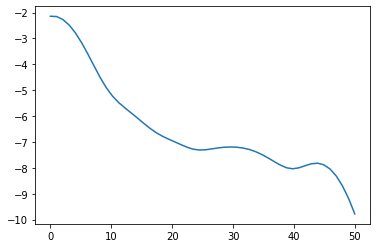

In [291]:
%matplotlib inline

from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot

a = array(data).reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(a)
s = linspace(0,50)
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)

In [292]:


from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])

Minima: [24.48979592 39.79591837]
Maxima: [29.59183673 43.87755102]


In [293]:
lower_range = s[mi][0]
upper_range = s[mi][1]

lower_range

24.48979591836735

In [294]:
print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.25000000e-01  0.00000000e+00  5.44660194e+00  0.00000000e+00
  0.00000000e+00  1.13333

[-1.1363636363636362, 39.5, 213.91325695581014, 410.1818181818182]

Minima: [19.3877551  33.67346939]
Maxima: [24.48979592 39.79591837]*italicized text*

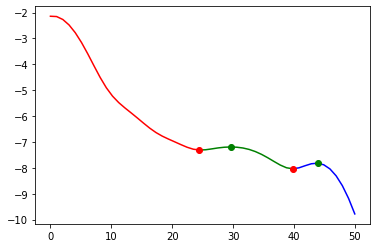

In [295]:
plot(s[:mi[0]+1], e[:mi[0]+1], 'r',
     s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',
     s[mi[1]:], e[mi[1]:], 'b',
     s[ma], e[ma], 'go',
     s[mi], e[mi], 'ro')

print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


## Labeling Data with Kernal density results

In [296]:
average_newCases_df3.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14,0.0,NaN,0.0
1,Amador County,6005,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0
2,Butte County,6007,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0
3,Calaveras County,6009,0.081633,2020-03-01,2020-03-14,0.0,NaN,0.0
4,Colusa County,6011,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0


In [297]:
print(lower_range, upper_range)

24.48979591836735 39.79591836734694


In [298]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range  else 'SuperSpread')


In [299]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range else ('Spread' if (x >= lower_range and x <= upper_range) else 'SuperSpread'))



#converter = lambda x : x*2 if x < 10 else (x*3 if x < 20 else x)



In [300]:
average_newCases_df3[average_newCases_df3['label'] == 'lessSpread'].count()

County Name         690
fips_x              690
average_per_week    690
startDate           690
endDate             690
diff_avg_x          690
shift_avg_x         636
percent_newcases    690
label               690
dtype: int64

In [301]:
average_newCases_df3[average_newCases_df3['label'] == 'Spread'].count()

County Name         7
fips_x              7
average_per_week    7
startDate           7
endDate             7
diff_avg_x          7
shift_avg_x         7
percent_newcases    7
label               7
dtype: int64

In [302]:
average_newCases_df3[average_newCases_df3['label'] == 'SuperSpread'].count()

County Name         4
fips_x              4
average_per_week    4
startDate           4
endDate             4
diff_avg_x          4
shift_avg_x         4
percent_newcases    4
label               4
dtype: int64

In [303]:
average_newCases_df3.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,label
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14,0.0,NaN,0.0,lessSpread
1,Amador County,6005,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,lessSpread
2,Butte County,6007,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,lessSpread
3,Calaveras County,6009,0.081633,2020-03-01,2020-03-14,0.0,NaN,0.0,lessSpread
4,Colusa County,6011,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,lessSpread


# 2.1 Loading CA - Social Distancing Inertia Maryland Data

In [304]:
CA_combined_sd_inertia_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/CA_socialDistancingInertiaData_Sep09.csv',low_memory=False)
CA_combined_sd_inertia_data.head()

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases
0,2020-01-22,California,6001,0,0,0,0,0,6001,Alameda County,6,18,20,3.29,29.4,0.3,35.9,0.55,2.74,0,1666753,-2.9,2020-01-22,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,0,1.2,3.9,5.7,0.3,0.0,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0
1,2020-01-23,California,6001,0,0,0,0,0,6001,Alameda County,6,15,19,3.36,29.6,0.3,35.4,0.56,2.80,0,1666753,-0.8,2020-01-23,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,0,1.2,3.9,5.7,0.3,0.0,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0
2,2020-01-24,California,6001,0,0,0,0,0,6001,Alameda County,6,15,19,3.48,29.0,0.3,39.1,0.53,2.94,0,1666753,4.1,2020-01-24,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,0,1.2,3.9,5.7,0.3,0.0,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0
3,2020-01-25,California,6001,0,0,0,0,0,6001,Alameda County,6,30,24,3.16,26.6,0.3,36.3,0.27,2.88,0,1666753,2.0,2020-01-25,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,0,1.2,3.9,5.7,0.3,0.0,0.0,0.0,1,54.0,0.0,0.0,0.0,0,0
4,2020-01-26,California,6001,0,0,0,0,0,6001,Alameda County,6,41,28,2.80,25.6,0.4,35.4,0.24,2.56,0,1666753,-9.3,2020-01-26,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,0,1.1,3.9,5.7,0.3,0.0,0.0,0.0,2,54.0,0.0,0.0,0.0,0,0


In [305]:
CA_combined_sd_inertia_data.FIPS.unique()

array([6001, 6003, 6005, 6007, 6009, 6011, 6013, 6015, 6017, 6019, 6021,
       6023, 6025, 6027, 6029, 6031, 6033, 6035, 6037, 6039, 6041, 6043,
       6045, 6047, 6049, 6051, 6053, 6055, 6057, 6059, 6061, 6063, 6065,
       6067, 6069, 6071, 6073, 6075, 6077, 6079, 6081, 6083, 6085, 6087,
       6089, 6091, 6093, 6095, 6097, 6099, 6101, 6103, 6105, 6107, 6109,
       6111, 6113, 6115])

## Computing rolling average

In [306]:
CA_combined_sd_inertia_data.columns

Index(['Date', 'Province_State', 'FIPS', 'Confirmed', 'Deaths', 'New cases',
       'New deaths', 'mask_rule_active', 'CTFIPS', 'CTNAME', 'STFIPS',
       'Social distancing index', '% staying home', 'Trips/person',
       '% out-of-county trips', '% out-of-state trips', 'Miles/person',
       'Work trips/person', 'Non-work trips/person', 'New COVID cases',
       'Population', '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people',
       '# contact tracing workers/1000 people rank',
       '% people older than 60 rank', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation

In [307]:
#new case column nume = 5
CA_combined_sd_inertia_data.iloc[:,5]

0         0
1         0
2         0
3         0
4         0
         ..
12291    18
12292     0
12293    28
12294    35
12295     0
Name: New cases, Length: 12296, dtype: int64

removing comuns: 
'Confirmed', 'Deaths', 'New deaths','#days: decreasing ILI cases', '#days: decreasing COVID cases', 'New cases/1000 people', 'Imported COVID cases' ,'COVID death rate',  'Active cases/1000 people',

In [308]:
df = pd.DataFrame(columns=['Date', 'Province_State', 'FIPS',  'New cases',
        'mask_rule_active', 'CTFIPS', 'CTNAME', 'STFIPS',
       'Social distancing index', '% staying home', 'Trips/person',
       '% out-of-county trips', '% out-of-state trips', 'Miles/person',
       'Work trips/person', 'Non-work trips/person', 'New COVID cases',
       'Population', '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people',
       '# contact tracing workers/1000 people rank',
       '% people older than 60 rank', 'COVID exposure/1000 people',
        'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation rate',
        '% hospital bed utilization',
       'Testing capacity', 'Tests done/1000 people', '% ICU utilization',
       'Ventilator shortage'])


In [309]:
CA_counties = CA_combined_sd_inertia_data['CTNAME'].unique()

for county in CA_counties:
  county_data = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['CTNAME'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases'] = county_data.iloc[:,5].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,California,6001,0,0,6001,Alameda County,6,18,20,3.29,29.4,0.3,35.9,0.55,2.74,0,1666753,-2.9,2020-01-22,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,2020-01-23,California,6001,0,0,6001,Alameda County,6,15,19,3.36,29.6,0.3,35.4,0.56,2.80,0,1666753,-0.8,2020-01-23,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2020-01-24,California,6001,0,0,6001,Alameda County,6,15,19,3.48,29.0,0.3,39.1,0.53,2.94,0,1666753,4.1,2020-01-24,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,2020-01-25,California,6001,0,0,6001,Alameda County,6,30,24,3.16,26.6,0.3,36.3,0.27,2.88,0,1666753,2.0,2020-01-25,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
4,2020-01-26,California,6001,0,0,6001,Alameda County,6,41,28,2.80,25.6,0.4,35.4,0.24,2.56,0,1666753,-9.3,2020-01-26,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,1.1,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,NaN


In [310]:
print(df.shape)
CA_combined_sd_inertia_data.shape

(12296, 54)


(12296, 53)

In [311]:
CA_combined_sd_inertia_data = df.copy()
CA_combined_sd_inertia_data

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,California,6001,0,0,6001,Alameda County,6,18,20,3.29,29.4,0.3,35.9,0.55,2.74,0,1666753,-2.9,2020-01-22,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.00,1.2,3.9,5.7,0.30,54.000000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0,NaN
1,2020-01-23,California,6001,0,0,6001,Alameda County,6,15,19,3.36,29.6,0.3,35.4,0.56,2.80,0,1666753,-0.8,2020-01-23,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.00,1.2,3.9,5.7,0.30,54.000000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0,NaN
2,2020-01-24,California,6001,0,0,6001,Alameda County,6,15,19,3.48,29.0,0.3,39.1,0.53,2.94,0,1666753,4.1,2020-01-24,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.00,1.2,3.9,5.7,0.30,54.000000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0,NaN
3,2020-01-25,California,6001,0,0,6001,Alameda County,6,30,24,3.16,26.6,0.3,36.3,0.27,2.88,0,1666753,2.0,2020-01-25,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.00,1.2,3.9,5.7,0.30,54.000000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,1.0,0.0,NaN
4,2020-01-26,California,6001,0,0,6001,Alameda County,6,41,28,2.80,25.6,0.4,35.4,0.24,2.56,0,1666753,-9.3,2020-01-26,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.00,1.1,3.9,5.7,0.30,54.000000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,2.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12291,2020-08-16,California,6115,18,1,6115,Yuba County,6,40,27,2.65,49.3,0.8,45.1,0.18,2.47,18,78041,-12.1,2020-08-16,0.94,17,52624,3.1,27.8,50.96,117,27,76,2.05,0.22,NaN,NaN,6,48.19,5.4,27.3,26.9,1.71,60.731048,6.3,247.70,20.87,1294,758.0,4.0,0.0,140.0,0.58,0.2990,6.27,0.0,517.0,22.571429
12292,2020-08-17,California,6115,0,1,6115,Yuba County,6,37,23,2.66,47.5,0.5,42.0,0.32,2.34,0,78041,-16.7,2020-08-17,0.94,17,52624,3.1,27.8,50.96,117,27,76,2.05,0.22,NaN,NaN,6,48.19,5.4,27.3,26.9,1.71,60.762511,6.3,251.13,20.77,1298,758.0,4.0,0.0,140.0,0.58,0.0769,6.22,1.0,479.0,16.000000
12293,2020-08-18,California,6115,28,1,6115,Yuba County,6,31,22,2.82,46.3,0.4,51.6,0.33,2.49,28,78041,-11.3,2020-08-18,0.94,17,52624,3.1,27.8,50.96,117,27,76,2.05,0.22,NaN,NaN,6,48.19,5.4,27.3,26.9,1.71,60.788291,6.3,254.04,20.66,1301,786.0,4.0,0.0,140.0,0.58,0.1965,6.28,2.0,472.0,17.142857
12294,2020-08-19,California,6115,35,1,6115,Yuba County,6,31,23,3.11,41.7,0.3,43.5,0.34,2.77,35,78041,-1.4,2020-08-19,0.94,17,52624,3.1,27.8,50.96,117,27,76,2.05,0.22,NaN,NaN,6,48.19,5.4,27.3,26.9,1.71,60.948422,6.3,256.36,20.20,1334,821.0,4.0,0.0,140.0,0.58,0.2691,6.23,3.0,470.0,20.428571


In [312]:
CA_combined_sd_inertia_data.head(3)

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,California,6001,0,0,6001,Alameda County,6,18,20,3.29,29.4,0.3,35.9,0.55,2.74,0,1666753,-2.9,2020-01-22,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,2020-01-23,California,6001,0,0,6001,Alameda County,6,15,19,3.36,29.6,0.3,35.4,0.56,2.80,0,1666753,-0.8,2020-01-23,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2020-01-24,California,6001,0,0,6001,Alameda County,6,15,19,3.48,29.0,0.3,39.1,0.53,2.94,0,1666753,4.1,2020-01-24,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## clean data - fill NA 

In [313]:
CA_combined_sd_inertia_data = CA_combined_sd_inertia_data.fillna(0)
CA_combined_sd_inertia_data.head(4)

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,California,6001,0,0,6001,Alameda County,6,18,20,3.29,29.4,0.3,35.9,0.55,2.74,0,1666753,-2.9,2020-01-22,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,California,6001,0,0,6001,Alameda County,6,15,19,3.36,29.6,0.3,35.4,0.56,2.80,0,1666753,-0.8,2020-01-23,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,California,6001,0,0,6001,Alameda County,6,15,19,3.48,29.0,0.3,39.1,0.53,2.94,0,1666753,4.1,2020-01-24,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,California,6001,0,0,6001,Alameda County,6,30,24,3.16,26.6,0.3,36.3,0.27,2.88,0,1666753,2.0,2020-01-25,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [314]:
CA_combined_sd_inertia_data['CTNAME'].unique()

array(['Alameda County', 'Alpine County', 'Amador County', 'Butte County',
       'Calaveras County', 'Colusa County', 'Contra Costa County',
       'Del Norte County', 'El Dorado County', 'Fresno County',
       'Glenn County', 'Humboldt County', 'Imperial County',
       'Inyo County', 'Kern County', 'Kings County', 'Lake County',
       'Lassen County', 'Los Angeles County', 'Madera County',
       'Marin County', 'Mariposa County', 'Mendocino County',
       'Merced County', 'Modoc County', 'Mono County', 'Monterey County',
       'Napa County', 'Nevada County', 'Orange County', 'Placer County',
       'Plumas County', 'Riverside County', 'Sacramento County',
       'San Benito County', 'San Bernardino County', 'San Diego County',
       'San Francisco County', 'San Joaquin County',
       'San Luis Obispo County', 'San Mateo County',
       'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County',
       'Shasta County', 'Sierra County', 'Siskiyou County',
       'Solano 

## verifying Rolling average with visualizations

In [315]:
los_angeles_county = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['CTNAME'] == 'Los Angeles County']
print(los_angeles_county.shape)
los_angeles_county.head()

(212, 54)


,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
3816,2020-01-22,California,6037,0,0,6037,Los Angeles County,6,18,19,3.34,10.9,0.3,32.5,0.62,2.72,0,10105518,-1.7,2020-01-22,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3817,2020-01-23,California,6037,0,0,6037,Los Angeles County,6,15,19,3.43,10.9,0.4,34.7,0.63,2.80,0,10105518,1.2,2020-01-23,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3818,2020-01-24,California,6037,0,0,6037,Los Angeles County,6,14,18,3.53,11.1,0.4,37.4,0.60,2.93,0,10105518,5.9,2020-01-24,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3819,2020-01-25,California,6037,0,0,6037,Los Angeles County,6,25,22,3.24,11.8,0.4,34.6,0.31,2.93,0,10105518,5.9,2020-01-25,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3820,2020-01-26,California,6037,1,0,6037,Los Angeles County,6,37,27,2.83,11.5,0.5,33.5,0.26,2.57,1,10105518,-7.1,2020-01-26,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.0,1.1,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


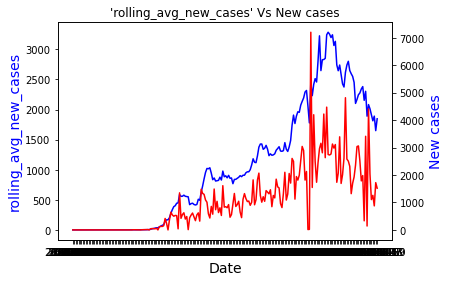

In [316]:
fig,ax = plt.subplots()
# make a plot
ax.plot(los_angeles_county.Date, los_angeles_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(los_angeles_county.Date, los_angeles_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

In [317]:
suffolk_county = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['CTNAME'] == 'Santa Clara County']

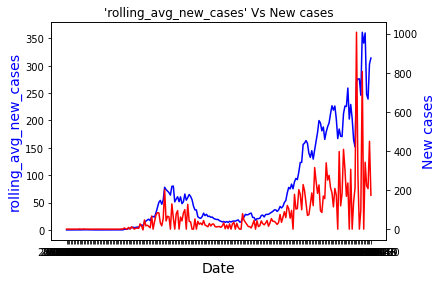

In [318]:
fig,ax = plt.subplots()
# make a plot
ax.plot(suffolk_county.Date, suffolk_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(suffolk_county.Date, suffolk_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

## Rolling window to compare every 2 weeks with next 2 weeks

In [319]:
CA_combined_sd_inertia_data = CA_combined_sd_inertia_data.sort_values(by=['Date'])
CA_combined_sd_inertia_data.head()

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,California,6001,0,0,6001,Alameda County,6,18,20,3.29,29.4,0.3,35.9,0.55,2.74,0,1666753,-2.9,2020-01-22,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4240,2020-01-22,California,6041,0,0,6041,Marin County,6,15,20,3.42,27.8,0.1,42.3,0.52,2.90,0,259666,2.5,2020-01-22,9.51,28,110217,2.2,15.9,48.83,314,308,218,2.05,0.22,0.0,0.0,73,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4028,2020-01-22,California,6039,0,0,6039,Madera County,6,18,17,3.55,29.7,0.1,39.9,0.52,3.03,0,157672,1.5,2020-01-22,0.45,19,52884,3.1,57.3,48.18,72,29,81,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10812,2020-01-22,California,6103,0,0,6103,Tehama County,6,18,19,3.47,30.1,1.9,50.6,0.55,2.93,0,63916,5.1,2020-01-22,0.33,26,42899,0.7,24.7,49.71,21,6,106,2.05,0.22,0.0,0.0,59,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3816,2020-01-22,California,6037,0,0,6037,Los Angeles County,6,18,19,3.34,10.9,0.3,32.5,0.62,2.72,0,10105518,-1.7,2020-01-22,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [320]:
CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['FIPS'] == 6037]

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
3816,2020-01-22,California,6037,0,0,6037,Los Angeles County,6,18,19,3.34,10.9,0.3,32.5,0.62,2.72,0,10105518,-1.7,2020-01-22,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.00,1.2,3.9,5.7,0.30,54.000000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0,0.000000
3817,2020-01-23,California,6037,0,0,6037,Los Angeles County,6,15,19,3.43,10.9,0.4,34.7,0.63,2.80,0,10105518,1.2,2020-01-23,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.00,1.2,3.9,5.7,0.30,54.000000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0,0.000000
3818,2020-01-24,California,6037,0,0,6037,Los Angeles County,6,14,18,3.53,11.1,0.4,37.4,0.60,2.93,0,10105518,5.9,2020-01-24,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.00,1.2,3.9,5.7,0.30,54.000000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0,0.000000
3819,2020-01-25,California,6037,0,0,6037,Los Angeles County,6,25,22,3.24,11.8,0.4,34.6,0.31,2.93,0,10105518,5.9,2020-01-25,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.00,1.2,3.9,5.7,0.30,54.000000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,1.0,0.0,0.000000
3820,2020-01-26,California,6037,1,0,6037,Los Angeles County,6,37,27,2.83,11.5,0.5,33.5,0.26,2.57,1,10105518,-7.1,2020-01-26,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.00,1.1,3.9,5.7,0.30,54.000000,0.0,0.00,0.00,0,1.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023,2020-08-16,California,6037,1104,1,6037,Los Angeles County,6,43,32,2.76,11.7,0.9,46.1,0.20,2.56,1104,10105518,-7.4,2020-08-16,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,48.19,5.4,27.3,26.9,1.71,60.731048,6.3,247.70,20.87,1294,221971.0,5254.0,8.0,140.0,0.58,0.2489,6.27,4.0,13295.0,1915.428571
4024,2020-08-17,California,6037,1259,1,6037,Los Angeles County,6,39,29,2.79,11.0,0.9,45.7,0.42,2.38,1259,10105518,-13.9,2020-08-17,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,48.19,5.4,27.3,26.9,1.71,60.762511,6.3,251.13,20.77,1298,223230.0,5273.0,19.0,140.0,0.58,0.1451,6.22,5.0,11997.0,1812.428571
4025,2020-08-18,California,6037,875,1,6037,Los Angeles County,6,37,28,2.86,11.0,0.8,44.7,0.43,2.43,875,10105518,-12.1,2020-08-18,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,48.19,5.4,27.3,26.9,1.71,60.788291,6.3,254.04,20.66,1301,224105.0,5340.0,67.0,140.0,0.58,0.1068,6.28,6.0,12288.0,1890.142857
4026,2020-08-19,California,6037,1722,1,6037,Los Angeles County,6,37,29,2.89,11.1,0.9,46.5,0.43,2.46,1722,10105518,-11.1,2020-08-19,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,48.19,5.4,27.3,26.9,1.71,60.948422,6.3,256.36,20.20,1334,225827.0,5392.0,52.0,140.0,0.58,0.1272,6.23,7.0,12491.0,1649.142857


In [321]:
minDate = CA_combined_sd_inertia_data['Date'].min()
print(minDate)

dateList = CA_combined_sd_inertia_data['Date'].unique()

2020-01-22


In [322]:
import datetime

#dt_object = datetime.fromtimestamp(date)
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

day = datetime.datetime.strptime(minDate, '%Y-%m-%d').weekday()
if day == 6:
  day =0
elif day < 6:
  day += 1

print(day)

3


In [323]:
index = 0
count = 0
lst = []
while index < len(dateList):
  row = []
  j = 14 - day;
  # print(index,j)
  # print(dateList[index:index+j])
  weekRange = dateList[index:index+j]
  #print(weekRange)
  index = index+j 
  day = 0
  count +=1
  row.append(count)
  row.append(weekRange.min())
  row.append(weekRange.max())
  print(row)
  lst.append(row)
  


[1, '2020-01-22', '2020-02-01']
[2, '2020-02-02', '2020-02-15']
[3, '2020-02-16', '2020-02-29']
[4, '2020-03-01', '2020-03-14']
[5, '2020-03-15', '2020-03-28']
[6, '2020-03-29', '2020-04-11']
[7, '2020-04-12', '2020-04-25']
[8, '2020-04-26', '2020-05-09']
[9, '2020-05-10', '2020-05-23']
[10, '2020-05-24', '2020-06-06']
[11, '2020-06-07', '2020-06-20']
[12, '2020-06-21', '2020-07-04']
[13, '2020-07-05', '2020-07-18']
[14, '2020-07-19', '2020-08-01']
[15, '2020-08-02', '2020-08-15']
[16, '2020-08-16', '2020-08-20']


In [324]:
week_df = pd.DataFrame(lst,index=None,columns=['WeekNumber','startDate','endDate'])
week_df.head(2)

,WeekNumber,startDate,endDate
0,1,2020-01-22,2020-02-01
1,2,2020-02-02,2020-02-15


## Slice data for the week dataframe

In [325]:

average_newCases_df = pd.DataFrame(columns=['CTNAME',  'FIPS',  'average_per_week','startDate','endDate'])

for index, row in week_df.iterrows():
    startDate, endDate = row['startDate'], row['endDate']
    df_index = (CA_combined_sd_inertia_data['Date'] >= startDate) & (CA_combined_sd_inertia_data['Date'] <= endDate)
    df_weekData =  CA_combined_sd_inertia_data.loc[df_index]
    df_base = (
      df_weekData
      .pipe(lambda x: x.assign(gains_pctg=x["rolling_avg_new_cases"]))
      .groupby(['CTNAME','FIPS'])
      .agg({"gains_pctg": "mean"})
      .reset_index()
      .rename(columns={"gains_pctg": "average_per_week"})
    )
    df_base['startDate'] = startDate
    df_base['endDate'] = endDate
  
    #print(startDate,endDate,df_base['average_per_week'])
    average_newCases_df = average_newCases_df.append(df_base)


In [326]:
average_newCases_df.shape

(928, 5)

In [327]:
average_newCases_df[average_newCases_df['FIPS'] == 6037]

,CTNAME,FIPS,average_per_week,startDate,endDate
18,Los Angeles County,6037,0.064935,2020-01-22,2020-02-01
18,Los Angeles County,6037,0.000000,2020-02-02,2020-02-15
18,Los Angeles County,6037,0.000000,2020-02-16,2020-02-29
18,Los Angeles County,6037,1.969388,2020-03-01,2020-03-14
18,Los Angeles County,6037,65.061224,2020-03-15,2020-03-28
18,Los Angeles County,6037,460.224490,2020-03-29,2020-04-11
18,Los Angeles County,6037,625.520408,2020-04-12,2020-04-25
18,Los Angeles County,6037,882.826531,2020-04-26,2020-05-09
18,Los Angeles County,6037,884.377551,2020-05-10,2020-05-23
18,Los Angeles County,6037,1259.887755,2020-05-24,2020-06-06


## Verifying average per week data Eg., Los Angeles County

In [328]:
los_angeles_county[(los_angeles_county['Date'] >= '2020-03-01') & (los_angeles_county['Date'] <= '2020-03-14') ]['rolling_avg_new_cases']



3855    0.000000
3856    0.000000
3857    0.000000
3858    0.857143
3859    1.428571
3860    1.714286
3861    1.857143
3862    1.857143
3863    1.857143
3864    2.714286
3865    2.857143
3866    3.000000
3867    3.857143
3868    5.571429
Name: rolling_avg_new_cases, dtype: float64

In [329]:
average_newCases_df.head(10)

,CTNAME,FIPS,average_per_week,startDate,endDate
0,Alameda County,6001,0.0,2020-01-22,2020-02-01
1,Alpine County,6003,0.0,2020-01-22,2020-02-01
2,Amador County,6005,0.0,2020-01-22,2020-02-01
3,Butte County,6007,0.0,2020-01-22,2020-02-01
4,Calaveras County,6009,0.0,2020-01-22,2020-02-01
5,Colusa County,6011,0.0,2020-01-22,2020-02-01
6,Contra Costa County,6013,0.0,2020-01-22,2020-02-01
7,Del Norte County,6015,0.0,2020-01-22,2020-02-01
8,El Dorado County,6017,0.0,2020-01-22,2020-02-01
9,Fresno County,6019,0.0,2020-01-22,2020-02-01


## Finding the % growth or reduction in 'new cases' on every 2 week average

In [330]:
average_newCases_df_ = average_newCases_df.copy()

In [331]:
albany_avg_newCases = average_newCases_df[average_newCases_df['CTNAME'] == 'Los Angeles County']
albany_avg_newCases

,CTNAME,FIPS,average_per_week,startDate,endDate
18,Los Angeles County,6037,0.064935,2020-01-22,2020-02-01
18,Los Angeles County,6037,0.000000,2020-02-02,2020-02-15
18,Los Angeles County,6037,0.000000,2020-02-16,2020-02-29
18,Los Angeles County,6037,1.969388,2020-03-01,2020-03-14
18,Los Angeles County,6037,65.061224,2020-03-15,2020-03-28
18,Los Angeles County,6037,460.224490,2020-03-29,2020-04-11
18,Los Angeles County,6037,625.520408,2020-04-12,2020-04-25
18,Los Angeles County,6037,882.826531,2020-04-26,2020-05-09
18,Los Angeles County,6037,884.377551,2020-05-10,2020-05-23
18,Los Angeles County,6037,1259.887755,2020-05-24,2020-06-06


In [332]:
average_newCases_df.head()

,CTNAME,FIPS,average_per_week,startDate,endDate
0,Alameda County,6001,0.0,2020-01-22,2020-02-01
1,Alpine County,6003,0.0,2020-01-22,2020-02-01
2,Amador County,6005,0.0,2020-01-22,2020-02-01
3,Butte County,6007,0.0,2020-01-22,2020-02-01
4,Calaveras County,6009,0.0,2020-01-22,2020-02-01


In [333]:
average_newCases_df2 = pd.DataFrame()
average_newCases_df2 = average_newCases_df.copy()

average_newCases_df2 = average_newCases_df2.reset_index(drop=True)
average_newCases_df2.head()

,CTNAME,FIPS,average_per_week,startDate,endDate
0,Alameda County,6001,0.0,2020-01-22,2020-02-01
1,Alpine County,6003,0.0,2020-01-22,2020-02-01
2,Amador County,6005,0.0,2020-01-22,2020-02-01
3,Butte County,6007,0.0,2020-01-22,2020-02-01
4,Calaveras County,6009,0.0,2020-01-22,2020-02-01


In [334]:
average_newCases_df2['diff_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['CTNAME', 'FIPS'])['average_per_week'].diff().fillna(0)

print(average_newCases_df2.shape)
average_newCases_df2.head()


(928, 6)


,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.0,2020-01-22,2020-02-01,0.0
1,Alpine County,6003,0.0,2020-01-22,2020-02-01,0.0
2,Amador County,6005,0.0,2020-01-22,2020-02-01,0.0
3,Butte County,6007,0.0,2020-01-22,2020-02-01,0.0
4,Calaveras County,6009,0.0,2020-01-22,2020-02-01,0.0


In [335]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Santa Clara County']

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
42,Santa Clara County,6085,0.025974,2020-01-22,2020-02-01,0.000000
100,Santa Clara County,6085,0.122449,2020-02-02,2020-02-15,0.096475
158,Santa Clara County,6085,0.010204,2020-02-16,2020-02-29,-0.112245
216,Santa Clara County,6085,3.857143,2020-03-01,2020-03-14,3.846939
274,Santa Clara County,6085,27.683673,2020-03-15,2020-03-28,23.826531
332,Santa Clara County,6085,64.071429,2020-03-29,2020-04-11,36.387755
390,Santa Clara County,6085,44.244898,2020-04-12,2020-04-25,-19.826531
448,Santa Clara County,6085,21.989796,2020-04-26,2020-05-09,-22.255102
506,Santa Clara County,6085,15.918367,2020-05-10,2020-05-23,-6.071429
564,Santa Clara County,6085,24.785714,2020-05-24,2020-06-06,8.867347


In [336]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Alameda County']

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.000000,2020-01-22,2020-02-01,0.000000
58,Alameda County,6001,0.000000,2020-02-02,2020-02-15,0.000000
116,Alameda County,6001,0.000000,2020-02-16,2020-02-29,0.000000
174,Alameda County,6001,0.357143,2020-03-01,2020-03-14,0.357143
232,Alameda County,6001,10.632653,2020-03-15,2020-03-28,10.275510
290,Alameda County,6001,37.051020,2020-03-29,2020-04-11,26.418367
348,Alameda County,6001,44.142857,2020-04-12,2020-04-25,7.091837
406,Alameda County,6001,41.469388,2020-04-26,2020-05-09,-2.673469
464,Alameda County,6001,50.102041,2020-05-10,2020-05-23,8.632653
522,Alameda County,6001,72.306122,2020-05-24,2020-06-06,22.204082


In [337]:
average_newCases_df2[average_newCases_df2['FIPS'] == 6037].head(5)

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
18,Los Angeles County,6037,0.064935,2020-01-22,2020-02-01,0.000000
76,Los Angeles County,6037,0.000000,2020-02-02,2020-02-15,-0.064935
134,Los Angeles County,6037,0.000000,2020-02-16,2020-02-29,0.000000
192,Los Angeles County,6037,1.969388,2020-03-01,2020-03-14,1.969388
250,Los Angeles County,6037,65.061224,2020-03-15,2020-03-28,63.091837


In [338]:
average_newCases_df2.head()

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.0,2020-01-22,2020-02-01,0.0
1,Alpine County,6003,0.0,2020-01-22,2020-02-01,0.0
2,Amador County,6005,0.0,2020-01-22,2020-02-01,0.0
3,Butte County,6007,0.0,2020-01-22,2020-02-01,0.0
4,Calaveras County,6009,0.0,2020-01-22,2020-02-01,0.0


In [339]:
average_newCases_df2 = average_newCases_df2.fillna(0)

In [340]:
average_newCases_df2.head()

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.0,2020-01-22,2020-02-01,0.0
1,Alpine County,6003,0.0,2020-01-22,2020-02-01,0.0
2,Amador County,6005,0.0,2020-01-22,2020-02-01,0.0
3,Butte County,6007,0.0,2020-01-22,2020-02-01,0.0
4,Calaveras County,6009,0.0,2020-01-22,2020-02-01,0.0


Shifting average_per_week_x	 column value for formula. Means previous row's value will be come to the current row.

In [341]:
average_newCases_df2['shift_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['CTNAME', 'FIPS'])['average_per_week'].shift()

In [342]:
average_newCases_df2.groupby(by=['CTNAME', 'FIPS','startDate','endDate']).sum()

average_per_week  ...  shift_avg_x
CTNAME         FIPS startDate  endDate                       ...             
Alameda County 6001 2020-01-22 2020-02-01          0.000000  ...     0.000000
                    2020-02-02 2020-02-15          0.000000  ...     0.000000
                    2020-02-16 2020-02-29          0.000000  ...     0.000000
                    2020-03-01 2020-03-14          0.357143  ...     0.000000
                    2020-03-15 2020-03-28         10.632653  ...     0.357143
...                                                     ...  ...          ...
Yuba County    6115 2020-06-21 2020-07-04          3.530612  ...     0.530612
                    2020-07-05 2020-07-18          9.785714  ...     3.530612
                    2020-07-19 2020-08-01         14.255102  ...     9.785714
                    2020-08-02 2020-08-15         18.255102  ...    14.255102
                    2020-08-16 2020-08-20         19.028571  ...    18.255102

[928 rows x 3 columns]

In [343]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Los Angeles County']

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x
18,Los Angeles County,6037,0.064935,2020-01-22,2020-02-01,0.000000,NaN
76,Los Angeles County,6037,0.000000,2020-02-02,2020-02-15,-0.064935,0.064935
134,Los Angeles County,6037,0.000000,2020-02-16,2020-02-29,0.000000,0.000000
192,Los Angeles County,6037,1.969388,2020-03-01,2020-03-14,1.969388,0.000000
250,Los Angeles County,6037,65.061224,2020-03-15,2020-03-28,63.091837,1.969388
308,Los Angeles County,6037,460.224490,2020-03-29,2020-04-11,395.163265,65.061224
366,Los Angeles County,6037,625.520408,2020-04-12,2020-04-25,165.295918,460.224490
424,Los Angeles County,6037,882.826531,2020-04-26,2020-05-09,257.306122,625.520408
482,Los Angeles County,6037,884.377551,2020-05-10,2020-05-23,1.551020,882.826531
540,Los Angeles County,6037,1259.887755,2020-05-24,2020-06-06,375.510204,884.377551


In [344]:
average_newCases_df2['percent_newcases'] = average_newCases_df2.apply(lambda x: (x.diff_avg_x) / x.shift_avg_x if x.shift_avg_x > 0.0 else 0 , axis=1)


average_newCases_df2.tail()


,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
923,Tulare County,6107,187.714286,2020-08-16,2020-08-20,6.540816,181.173469,0.036103
924,Tuolumne County,6109,1.057143,2020-08-16,2020-08-20,-0.616327,1.673469,-0.368293
925,Ventura County,6111,100.114286,2020-08-16,2020-08-20,-30.783673,130.897959,-0.235173
926,Yolo County,6113,34.314286,2020-08-16,2020-08-20,4.906122,29.408163,0.166829
927,Yuba County,6115,19.028571,2020-08-16,2020-08-20,0.773469,18.255102,0.042370


In [345]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Santa Clara County']

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
42,Santa Clara County,6085,0.025974,2020-01-22,2020-02-01,0.000000,NaN,0.000000
100,Santa Clara County,6085,0.122449,2020-02-02,2020-02-15,0.096475,0.025974,3.714286
158,Santa Clara County,6085,0.010204,2020-02-16,2020-02-29,-0.112245,0.122449,-0.916667
216,Santa Clara County,6085,3.857143,2020-03-01,2020-03-14,3.846939,0.010204,377.000000
274,Santa Clara County,6085,27.683673,2020-03-15,2020-03-28,23.826531,3.857143,6.177249
332,Santa Clara County,6085,64.071429,2020-03-29,2020-04-11,36.387755,27.683673,1.314412
390,Santa Clara County,6085,44.244898,2020-04-12,2020-04-25,-19.826531,64.071429,-0.309444
448,Santa Clara County,6085,21.989796,2020-04-26,2020-05-09,-22.255102,44.244898,-0.502998
506,Santa Clara County,6085,15.918367,2020-05-10,2020-05-23,-6.071429,21.989796,-0.276102
564,Santa Clara County,6085,24.785714,2020-05-24,2020-06-06,8.867347,15.918367,0.557051


# 2.2 Labeling data as per % change

In [346]:
average_newCases_df2.describe()

,FIPS,average_per_week,diff_avg_x,shift_avg_x,percent_newcases
count,928.000000,928.000000,928.000000,870.000000,928.000000
mean,6058.000000,54.337813,8.887948,48.479677,1.774538
std,33.499392,209.236234,60.820705,202.422624,14.296977
min,6001.000000,-0.173469,-528.826531,-0.173469,-2.200000
25%,6029.000000,0.000000,0.000000,0.000000,0.000000
50%,6058.000000,1.413265,0.081633,1.071429,0.000000
75%,6087.000000,22.645408,3.637755,18.091837,0.740395
max,6115.000000,2787.020408,819.357143,2787.020408,377.000000


In [347]:
los_angeles_county = average_newCases_df2[average_newCases_df2['CTNAME'] == 'Los Angeles County']

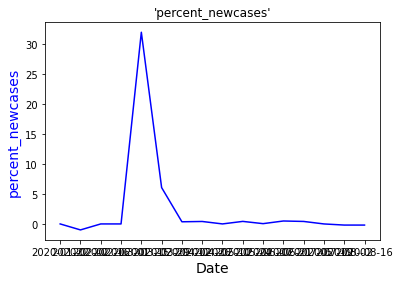

In [348]:
fig,ax = plt.subplots()
# make a plot
ax.plot(los_angeles_county.startDate, los_angeles_county['percent_newcases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("percent_newcases",color="blue",fontsize=14)
# ax2=ax.twinx()
# make a plot with different y-axis using second axis object
# ax2.plot(los_angeles_county.startDate, los_angeles_county["percent_newcases"],color="red")
# ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'percent_newcases'")

plt.show()

In [349]:
data = average_newCases_df2['percent_newcases'].to_list()

print(data)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.714285714285714, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -0.25000000000000006, 0.0, 0.0, 0.0, 0.0, 0.0, -0.9166666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0

In [350]:
average_newCases_df3 = average_newCases_df2.copy().reset_index(drop=True)

## Determining growth label

In [351]:
new_cases_list = average_newCases_df2['percent_newcases'].values
diffArr = np.diff(new_cases_list)
print(len(diffArr))
diffArr[0]

927


0.0

In [352]:
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA

print('growth_values : ',len(growth_values))
growth_values.extend(diffArr)
print('growth_values : ',len(growth_values))

growth_values :  1
growth_values :  928


In [353]:
average_newCases_df2['growth_per_day'] = growth_values


### Checking mean, std dev and variance for growth data


In [354]:
stdDev = np.std(diffArr)
variance = np.var(diffArr)
mean = np.mean(diffArr)
min = np.min(diffArr)
max = np.max(diffArr)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  -377.00000000000006
max  377.00000000000006
mean  4.570662257598492e-05
std. deviation  20.151388621585387
variance  406.07846337816096


### Getting positive cases

In [355]:
print('length diffArr: ',len(diffArr))

non_zero_pos_diff = []

for i in diffArr:
  if i > 0:
    non_zero_pos_diff.append(i)

print('non_zero_pos_diff length: ',len(non_zero_pos_diff))


length diffArr:  927
non_zero_pos_diff length:  351


In [356]:
stdDev = np.std(non_zero_pos_diff)
variance = np.var(non_zero_pos_diff)
mean = np.mean(non_zero_pos_diff)
min = np.min(non_zero_pos_diff)
max = np.max(non_zero_pos_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


min  0.0013773837468717964
max  377.00000000000006
mean  4.196743323399912
std. deviation  22.79037527125108
variance  519.4012050044528


### Getting negative cases

In [357]:
print('length diffArr: ',len(diffArr))

non_zero_neg_diff = []

for i in diffArr:
  if i < 0:
    non_zero_neg_diff.append(i)
print("non_zero_neg_diff length : ",len(non_zero_neg_diff))


length diffArr:  927
non_zero_neg_diff length :  343


In [358]:
stdDev = np.std(non_zero_neg_diff)
variance = np.var(non_zero_neg_diff)
mean = np.mean(non_zero_neg_diff)
min = np.min(non_zero_neg_diff)
max = np.max(non_zero_neg_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  -377.00000000000006
max  -0.009978229317851839
mean  -4.29450302179079
std. deviation  23.01077232087632
variance  529.4956428032078


### Applying Jenks Natural break

In [359]:

pos_breaks = jenkspy.jenks_breaks(non_zero_pos_diff, nb_class=2)
print(pos_breaks)
neg_breaks = jenkspy.jenks_breaks(non_zero_neg_diff, nb_class=2)
print(neg_breaks)

[0.0013773837468717964, 157.48611111111111, 377.00000000000006]
[-377.00000000000006, -156.93522372528616, -0.009978229317851839]


#### **Note**: 

From the positive and negative break, 
* [ -0.009978 , 0.001377 ] - flat growth
* [ 0.001377 , 157.486111 ] - mild growth
* [ 157.486111 , 377.00 ] - drastic growth
* [ -0.009978 , -157.486111 ] - mild decrement
* [ -157.486111, -377.00 ] - drastic decrement

In [360]:
def determine_growth_label_inertia(x):
  if x >= -0.009978 and x <= 0.001377:
    return 'flat_growth'
  if x > 0.001377 and x <= 157.486111:
    return 'mild_growth'
  if x > 157.486111 and x <= 377.00:
    return 'drastic_growth'
  if x >= -157.486111  and x <= -0.009978:
    return 'mild_decrement'
  if x >= -377.00 and x < -157.486111:
    return 'drastic_decrement'

In [361]:
average_newCases_df2['growth_label'] = average_newCases_df2['growth_per_day'].apply(lambda x: determine_growth_label_inertia(x) )

In [362]:
average_newCases_df2.head(3)

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label
0,Alameda County,6001,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,flat_growth
1,Alpine County,6003,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,flat_growth
2,Amador County,6005,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,flat_growth


In [363]:
average_newCases_df2_growth0 = average_newCases_df2[average_newCases_df2['growth_label'] == 'drastic_decrement']
average_newCases_df2_growth1 = average_newCases_df2[average_newCases_df2['growth_label'] == 'drastic_growth']
average_newCases_df2_growth2 = average_newCases_df2[average_newCases_df2['growth_label'] == 'flat_growth']
average_newCases_df2_growth3 = average_newCases_df2[average_newCases_df2['growth_label'] == 'mild_decrement']
average_newCases_df2_growth4 = average_newCases_df2[average_newCases_df2['growth_label'] == 'mild_growth']

print(average_newCases_df2_growth0.shape)
print(average_newCases_df2_growth1.shape)
print(average_newCases_df2_growth2.shape)
print(average_newCases_df2_growth3.shape)
print(average_newCases_df2_growth4.shape)

(0, 10)
(1, 10)
(234, 10)
(342, 10)
(349, 10)


## Jenks Natural breaks 

In [364]:
!pip install jenkspy


In [365]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=3)
print(breaks)

[-2.2, 44.0, 158.0, 377.00000000000006]


### Labeling criteria

We have applied "jenks Natural breaks' to label the county data as per 'percent change in cases'

From the natural break algorithm, we have splited the data as follows 

* -1.136 to 3.642 is **label 1** (least chance of spreading) 

* 3.642 to 13.625 is **label 2** (Below threshold but chances to reach super spread level)

* 13.625 to 410.181818 is **label 3** (Super spread week)

4 class labeling

In [366]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=4)
print(breaks)

[-2.2, 13.882352941176471, 58.923076923076934, 158.0, 377.00000000000006]


In [367]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread','SuperSpread2'])

In [368]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['CTNAME'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['CTNAME'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']['CTNAME'].count())

print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['CTNAME'].count())

Number of records in LessSpread: 910
Number of records in Spread: 14
Number of records in SuperSpread: 2
Number of records in SuperSpread: 1


8 class labeling

In [369]:
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=8)
print(breaks)

[-2.2, 2.0497737556561093, 7.910256410256411, 21.000000000000004, 37.282051282051285, 58.923076923076934, 86.23809523809521, 158.0, 377.00000000000006]


In [370]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread1','SuperSpread2','SuperSpread3','SuperSpread4','SuperSpread5','SuperSpread6'])

In [371]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['CTNAME'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['CTNAME'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread1']['CTNAME'].count())
print('Number of records in SuperSpread2:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['CTNAME'].count())
print('Number of records in SuperSpread3:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread3']['CTNAME'].count())
print('Number of records in SuperSpread4:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread4']['CTNAME'].count())
print('Number of records in SuperSpread5:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread5']['CTNAME'].count())
print('Number of records in SuperSpread6:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread6']['CTNAME'].count())

Number of records in LessSpread: 820
Number of records in Spread: 75
Number of records in SuperSpread: 19
Number of records in SuperSpread2: 8
Number of records in SuperSpread3: 2
Number of records in SuperSpread4: 1
Number of records in SuperSpread5: 1
Number of records in SuperSpread6: 1


In [372]:
average_newCases_df2.head()

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label,labels
0,Alameda County,6001,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,flat_growth,LessSpread
1,Alpine County,6003,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,flat_growth,LessSpread
2,Amador County,6005,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,flat_growth,LessSpread
3,Butte County,6007,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,flat_growth,LessSpread
4,Calaveras County,6009,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,flat_growth,LessSpread


# 2.3 Labeling data for CA -Maryland Social Distancing Inertia combined

In [373]:
CA_combined_sd_inertia_data.head(2)

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,California,6001,0,0,6001,Alameda County,6,18,20,3.29,29.4,0.3,35.9,0.55,2.74,0,1666753,-2.9,2020-01-22,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4240,2020-01-22,California,6041,0,0,6041,Marin County,6,15,20,3.42,27.8,0.1,42.3,0.52,2.90,0,259666,2.5,2020-01-22,9.51,28,110217,2.2,15.9,48.83,314,308,218,2.05,0.22,0.0,0.0,73,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [374]:
CA_combined_sd_inertia_data_ = CA_combined_sd_inertia_data.copy()

In [375]:
CA_combined_sd_inertia_data = CA_combined_sd_inertia_data_.copy().reset_index(drop=True)

In [376]:
#average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in tqdm(average_newCases_df2.iterrows()):
    startDate, endDate = row['startDate'], row['endDate']
    fips = row['FIPS']
    #print(startDate,endDate,fips)
    df_index = (CA_combined_sd_inertia_data['FIPS'] == row['FIPS']) & (CA_combined_sd_inertia_data['Date'] >= startDate) & (CA_combined_sd_inertia_data['Date'] <= endDate)
    df_weekData =  CA_combined_sd_inertia_data.loc[df_index]
    #print(df_weekData)
    CA_combined_sd_inertia_data.loc[df_index,'label'] = row['labels']
    CA_combined_sd_inertia_data.loc[df_index,'growth_label'] = row['growth_label']




928it [00:05, 166.10it/s]


In [377]:
CA_combined_sd_inertia_data.head(5)

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases,label,growth_label
0,2020-01-22,California,6001,0,0,6001,Alameda County,6,18,20,3.29,29.4,0.3,35.9,0.55,2.74,0,1666753,-2.9,2020-01-22,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth
1,2020-01-22,California,6041,0,0,6041,Marin County,6,15,20,3.42,27.8,0.1,42.3,0.52,2.90,0,259666,2.5,2020-01-22,9.51,28,110217,2.2,15.9,48.83,314,308,218,2.05,0.22,0.0,0.0,73,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth
2,2020-01-22,California,6039,0,0,6039,Madera County,6,18,17,3.55,29.7,0.1,39.9,0.52,3.03,0,157672,1.5,2020-01-22,0.45,19,52884,3.1,57.3,48.18,72,29,81,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth
3,2020-01-22,California,6103,0,0,6103,Tehama County,6,18,19,3.47,30.1,1.9,50.6,0.55,2.93,0,63916,5.1,2020-01-22,0.33,26,42899,0.7,24.7,49.71,21,6,106,2.05,0.22,0.0,0.0,59,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth
4,2020-01-22,California,6037,0,0,6037,Los Angeles County,6,18,19,3.34,10.9,0.3,32.5,0.62,2.72,0,10105518,-1.7,2020-01-22,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth


In [378]:
CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['label'] == 'SuperSpread2'].sort_values(by=['FIPS','Date']).count()

Date                                          112
Province_State                                112
FIPS                                          112
New cases                                     112
mask_rule_active                              112
CTFIPS                                        112
CTNAME                                        112
STFIPS                                        112
Social distancing index                       112
% staying home                                112
Trips/person                                  112
% out-of-county trips                         112
% out-of-state trips                          112
Miles/person                                  112
Work trips/person                             112
Non-work trips/person                         112
New COVID cases                               112
Population                                    112
% change in consumption                       112
date                                          112


In [379]:
CA_combined_sd_inertia_data.shape

(12296, 56)

In [380]:
CA_combined_sd_inertia_data['label'] = CA_combined_sd_inertia_data['label'].apply(lambda x: x if x != 'SuperSpread2' else 'SuperSpread')




In [381]:
CA_combined_sd_inertia_data_growth0 = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['growth_label'] == 'drastic_decrement']
CA_combined_sd_inertia_data_growth1 = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['growth_label'] == 'drastic_growth']
CA_combined_sd_inertia_data_growth2 = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['growth_label'] == 'flat_growth']
CA_combined_sd_inertia_data_growth3 = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['growth_label'] == 'mild_decrement']
CA_combined_sd_inertia_data_growth4 = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['growth_label'] == 'mild_growth']

print(CA_combined_sd_inertia_data_growth0.shape)
print(CA_combined_sd_inertia_data_growth1.shape)
print(CA_combined_sd_inertia_data_growth2.shape)
print(CA_combined_sd_inertia_data_growth3.shape)
print(CA_combined_sd_inertia_data_growth4.shape)


(0, 56)
(14, 56)
(3102, 56)
(4527, 56)
(4625, 56)


### Export Labeled Maryland Inertia Data

In [382]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'
filename = 'CA_sd_inertia_labeledData_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
CA_combined_sd_inertia_data.to_csv(location+filename,index=False)

CA_sd_inertia_labeledData_Sep18.csv


In [383]:
average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label,labels


## Kernal Density Estimation

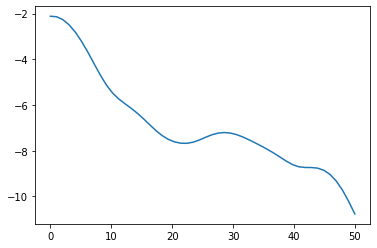

In [384]:
%matplotlib inline

from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot

a = array(data).reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(a)
s = linspace(0,50)
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)

In [385]:


from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])

Minima: [22.44897959]
Maxima: [28.57142857]


In [386]:
lower_range = s[mi][0]
upper_range = s[mi][1]

lower_range

IndexError: ignored

In [ ]:
print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


[-1.1363636363636362, 39.5, 213.91325695581014, 410.1818181818182]

Minima: [19.3877551  33.67346939]
Maxima: [24.48979592 39.79591837]*italicized text*

In [ ]:
plot(s[:mi[0]+1], e[:mi[0]+1], 'r',
     s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',
     s[mi[1]:], e[mi[1]:], 'b',
     s[ma], e[ma], 'go',
     s[mi], e[mi], 'ro')

print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


## Labeling Data with Kernal density results

In [ ]:
average_newCases_df3.head()

In [ ]:
print(lower_range, upper_range)

In [ ]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range  else 'SuperSpread')


In [ ]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range else ('Spread' if (x >= lower_range and x <= upper_range) else 'SuperSpread'))



#converter = lambda x : x*2 if x < 10 else (x*3 if x < 20 else x)



In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'lessSpread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'Spread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'SuperSpread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['growth_label'] == 'SuperSpread'].count()

In [ ]:
average_newCases_df3.head()

# unused code


In [ ]:
average_newCases_df2[average_newCases_df2['County Name'] != 'Queens County']

In [ ]:
average_newCases_df2.groupby(by=['County Name', 'fips_x','startDate','endDate']).sum()

In [ ]:
week_df.head()

In [ ]:
CA_combined_data.dtypes

In [ ]:
start_date_df = (
    CA_combined_data
    .merge(week_df, left_on=['Date'],right_on=['startDate'], how='inner')
    .pipe(lambda x: x.assign(date=x.Date))
    .rename(columns={"starting_rolling_avg_new_cases": "rolling_avg_new_cases"})
    .reset_index(drop=True)

    [['Date','fips_x','County Name','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','population_density','mask_rule_active','mask_wearing_percent','New cases','startDate','WeekNumber','rolling_avg_new_cases']]
    .pivot_table(values='rolling_avg_new_cases', columns='WeekNumber', index='County Name', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

start_date_df

In [ ]:
end_date_df = (
    CA_combined_data
    .merge(week_df, on='Date', how='inner')
    .pipe(lambda x: x.assign(date=x.Date))
    .rename(columns={"Confirmed": "end_date_Confirmed"})
    .reset_index(drop=True)

    [['County Name', 'fips_x', 'end_date_Confirmed','endDate','WeekNumber']]
    .pivot_table(values='end_date_Confirmed', columns='WeekNumber', index='County Name', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)